# Timeseries Data

Here we will be using the Daily Minimum Temperatures in Melbourne dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.



In [1]:
!pip install numpy tensorflow matplotlib dataclasses

^C


In [2]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass


  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/72/b2/02770e60c4e2f7e158d923ab0dea4e9f146a2dbf267fec6d8dc61d475689/numpy-1.25.2-cp311-cp311-win_amd64.whl.metadata
  Using cached numpy-1.25.2-cp311-cp311-win_amd64.whl.metadata (5.7 kB)
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/9e/b8/ed5f794359d05cd0bffb894c6418da87b93016ee17b669d55c45d1bd5d5b/tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl.metadata (2.6 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4d/9c/65830d4a56c47f5283eaa244dc1228c5da9c844a9f999ebcc2e69bf6cc65/matplotlib-3.7.2-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.7.2-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.py

In [2]:
@dataclass
class G:
    TEMPERATURES_CSV = pd.read_csv('daily-min-temperatures.csv')
    time, temperatures = list(TEMPERATURES_CSV['Date']), list(TEMPERATURES_CSV['Temp'])
    TIME = np.array(time)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

In [3]:
G.TEMPERATURES_CSV

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [4]:
## Functions

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

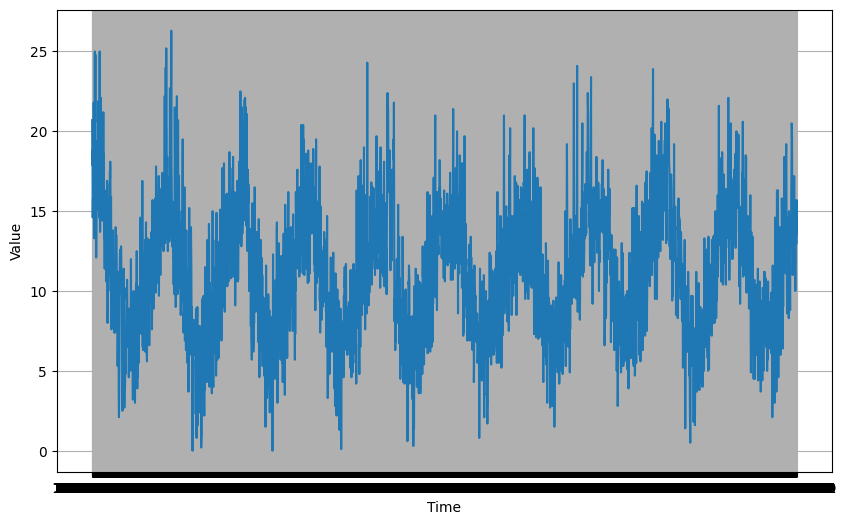

In [5]:
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [6]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [8]:
# Defining the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
]) 

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 85))

# optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

# Compile the model passing in the appropriate loss
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer, 
              metrics=["mae"]) 

lr_history = model.fit(train_set, epochs=150, callbacks=[lr_schedule])

Epoch 1/150
77/77 [==============================] - 9s 58ms/step - loss: 1.5356 - mae: 1.9785 - lr: 1.0000e-08
Epoch 2/150
77/77 [==============================] - 5s 59ms/step - loss: 1.4874 - mae: 1.9272 - lr: 1.0275e-08
Epoch 3/150
77/77 [==============================] - 5s 59ms/step - loss: 1.4850 - mae: 1.9246 - lr: 1.0557e-08
Epoch 4/150
77/77 [==============================] - 5s 60ms/step - loss: 1.4847 - mae: 1.9239 - lr: 1.0847e-08
Epoch 5/150
77/77 [==============================] - 5s 60ms/step - loss: 1.4859 - mae: 1.9267 - lr: 1.1144e-08
Epoch 6/150
77/77 [==============================] - 5s 61ms/step - loss: 1.4843 - mae: 1.9234 - lr: 1.1450e-08
Epoch 7/150
77/77 [==============================] - 5s 60ms/step - loss: 1.4850 - mae: 1.9247 - lr: 1.1765e-08
Epoch 8/150
77/77 [==============================] - 5s 61ms/step - loss: 1.4849 - mae: 1.9255 - lr: 1.2088e-08
Epoch 9/150
77/77 [==============================] - 5s 61ms/step - loss: 1.4846 - mae: 1.9241 - lr: 1.2

(1e-08, 1e-06, 0.0, 6.0)

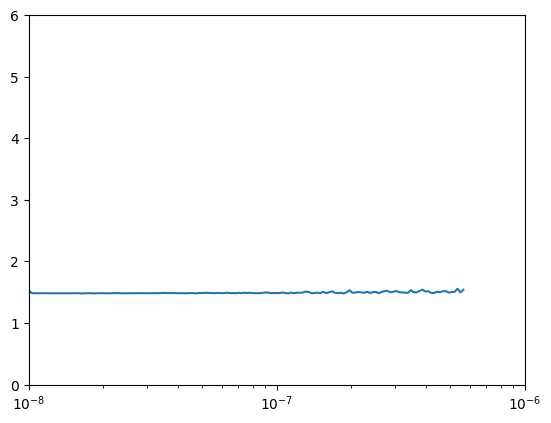

In [24]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-8, 1e-6, 0, 3])

In [25]:
# Compiling the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                  strides=1, padding="causal",
                  activation="relu",
                  input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics=["mae"])

In [26]:
history = model.fit(train_set, epochs=75)

Epoch 1/75
77/77 [==============================] - 9s 61ms/step - loss: 24.5168 - mae: 24.9951
Epoch 2/75
77/77 [==============================] - 5s 61ms/step - loss: 2.2378 - mae: 2.6955
Epoch 3/75
77/77 [==============================] - 5s 61ms/step - loss: 2.0698 - mae: 2.5251
Epoch 4/75
77/77 [==============================] - 5s 61ms/step - loss: 1.9675 - mae: 2.4211
Epoch 5/75
77/77 [==============================] - 5s 62ms/step - loss: 1.9184 - mae: 2.3685
Epoch 6/75
77/77 [==============================] - 5s 61ms/step - loss: 1.9729 - mae: 2.4286
Epoch 7/75
77/77 [==============================] - 5s 61ms/step - loss: 1.8954 - mae: 2.3515
Epoch 8/75
77/77 [==============================] - 5s 62ms/step - loss: 1.9066 - mae: 2.3607
Epoch 9/75
77/77 [==============================] - 5s 61ms/step - loss: 1.8937 - mae: 2.3454
Epoch 10/75
77/77 [==============================] - 5s 63ms/step - loss: 2.0596 - mae: 2.5147
Epoch 11/75
77/77 [==============================] - 5s 6

113/113 [==============================] - 4s 23ms/step


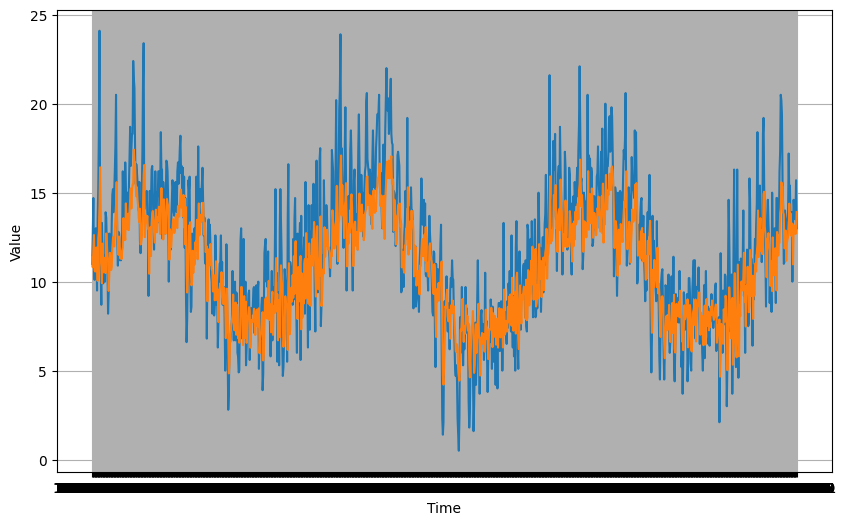

In [27]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [30]:
mse, mae = compute_metrics(series_valid, rnn_forecast)
print("Ideal Situation: MSE of 6 or less and a MAE of 2 or less.")
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")


Ideal Situation: MSE of 6 or less and a MAE of 2 or less.
mse: 6.17, mae: 1.95 for forecast
